In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##  $$A(t,T) = \Sigma_i A_i P(dI/dt (t)\otimes e^{-t/\tau_i})$$

In [2]:
def AofT(time,T, ai, taui):
    return ai*np.exp(-time/taui)/(1.+np.exp(-T/(2*taui)))

In [3]:
from SimPEG import *
import sys
sys.path.append("./DoubleLog/")
from plotting import mapDat

In [4]:
class LinearSurvey(Survey.BaseSurvey):
    nD = None
    def __init__(self, time, **kwargs): 
        self.time = time
        self.nD = time.size
        
    def projectFields(self, u):
        return u

class LinearProblem(Problem.BaseProblem):

    surveyPair = LinearSurvey

    def __init__(self, mesh, G, **kwargs):
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        self.G = G

    def fields(self, m, u=None):
        return self.G.dot(m)

    def Jvec(self, m, v, u=None):
        return self.G.dot(v)

    def Jtvec(self, m, v, u=None):
        return self.G.T.dot(v)


# Simple exponential basis


$$ \mathbf{A}\mathbf{\alpha} = \mathbf{d}$$

In [5]:
time = np.cumsum(np.r_[0., 1e-5*np.ones(10), 5e-5*np.ones(10), 1e-4*np.ones(10), 5e-4*np.ones(10), 1e-3*np.ones(10)])
# time = np.cumsum(np.r_[0., 1e-5*np.ones(10), 5e-5*np.ones(10),1e-4*np.ones(5)])
M = 41
tau = np.logspace(-4.1, -1, M)

In [16]:
from simpegem1d.Waveform import SineFun, SineFunDeriv, CausalConv
dt = 1e-5
P = meshtime.getInterpolationMat(time+t0, 'N')
time_conv = meshtime.gridN
t0 = 0.003
currentderiv = SineFunDeriv(time_conv, t0)
current = SineFun(time_conv, t0)

In [17]:
from SimPEG import Mesh
meshtime = Mesh.TensorMesh([np.ones(2**12-1)*dt], x0="0")

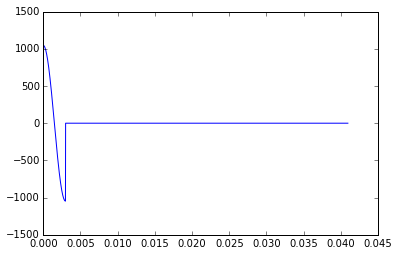

In [18]:
temp = np.exp(-time_conv/1e-2)
out = CausalConv(temp, currentderiv, time_conv)
plt.plot(time_conv, currentderiv)

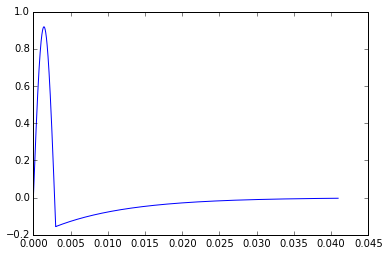

In [19]:
plt.plot(time_conv, out)

In [20]:
actind = time_conv>t0

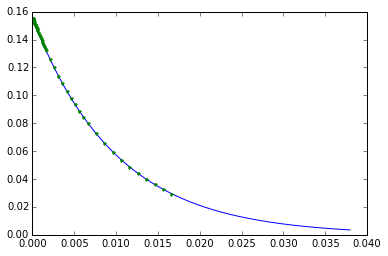

In [21]:
plt.plot(time_conv[actind]-t0, -out[actind])
plt.plot(time, -P*out, '.')

In [22]:
time_conv.min(), time_conv.max()

(0.0, 0.040950000000001867)

In [23]:
N = time.size
A = np.zeros((N, M))
for j in range(M):
    A[:,j] = P*(CausalConv(np.exp(-time_conv/tau[j]), -currentderiv, time_conv))

In [24]:
mtrue = np.zeros(M)

In [25]:
np.random.seed(1)
inds = np.random.random_integers(0, 41, size=5)
mtrue[inds] = np.r_[0.1, 2, 1, 4, 5]

In [26]:
out = np.dot(A,mtrue)

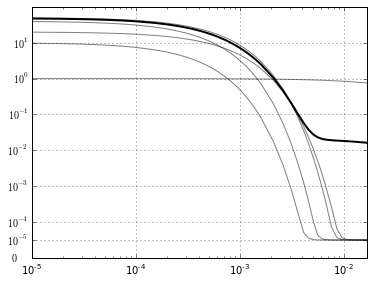

In [27]:
fig = plt.figure(figsize=(6,4.5))
ax = plt.subplot(111)

for i, ind in enumerate(inds):
    temp, dum, dum = mapDat(mtrue[inds][i]*np.exp(-time/tau[ind]), 1e-5, stretch=2)
    plt.semilogx(time, temp, 'k', alpha = 0.5)    
outmap, ticks, tickLabels = mapDat(out, 1e-5, stretch=2)    
ax.semilogx(time, outmap, 'k', lw=2)
ax.set_yticks(ticks)
ax.set_yticklabels(tickLabels)
# ax.set_ylim(ticks.min(), ticks.max())
ax.set_ylim(ticks.min(), ticks.max())
ax.set_xlim(time.min(), time.max())
ax.grid(True)

In [28]:
# from pymatsolver import MumpsSolver

In [29]:
mesh = Mesh.TensorMesh([M])
prob = LinearProblem(mesh, A)
survey = LinearSurvey(time)
survey.pair(prob)
survey.makeSyntheticData(mtrue, std=0.01)
# survey.dobs = out
reg = Regularization.BaseRegularization(mesh)
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(survey.dobs)+0.05*1e-2)
opt = Optimization.ProjectedGNCG(maxIter=20)
# opt = Optimization.InexactGaussNewton(maxIter=20)
opt.lower = -1e-10
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 1e-4
beta = Directives.BetaSchedule()
beta.coolingFactor = 2
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target])
m0 = np.zeros_like(survey.mtrue)
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.00e-04  6.65e+03  0.00e+00  6.65e+03    4.19e+04      0              
   1  1.00e-04  5.93e+03  1.94e-02  5.93e+03    2.85e+03      2              
   2  1.00e-04  5.85e+03  3.60e-02  5.85e+03    2.53e+03      4   Skip BFGS  
   3  5.00e-05  5.67e+03  6.36e-02  5.67e+03    2.30e+03      4   Skip BFGS  
   4  5.00e-05  4.51e+03  6.10e-02  4.51e+03    2.94e+03      0              
   5  5.00e-05  4.31e+03  9.57e-01  4.31e+03    7.37e+02      1              
   6  2.50e-05  2.55e+03  9.19e-01  2.55e+03    9.81e+02      0              
   7  2.50e-05  1.84e+03  3.16e

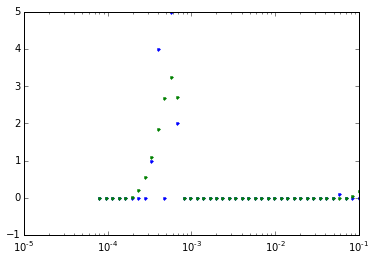

In [30]:
plt.semilogx(tau, mtrue, '.')
plt.semilogx(tau, mrec, '.')

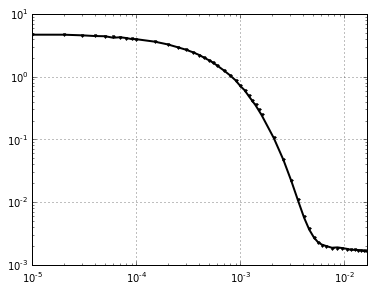

In [31]:
fig = plt.figure(figsize=(6,4.5))
ax = plt.subplot(111)
obsmap, ticks, tickLabels = mapDat(survey.dobs, 1e0, stretch=2)    
predmap, dum, dum = mapDat(invProb.dpred, 1e0, stretch=2)    
ax.loglog(time, survey.dobs, 'k', lw=2)
ax.loglog(time, invProb.dpred, 'k.', lw=2)
# ax.set_yticks(ticks)
# ax.set_yticklabels(tickLabels)
# ax.set_ylim(ticks.min(), ticks.max())
# ax.set_ylim(ticks.min(), ticks.max())
ax.set_xlim(time.min(), time.max())
ax.grid(True)